In [1]:

import os
import random
import time
import numpy as np
import pandas as pd
import tensorflow as tf

# Global reproducibility 
SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
os.environ["TF_DETERMINISTIC_OPS"] = "1"
try:
    # For cuDNN determinism (if using GPU)
    os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
except Exception:
    pass

def set_seed(s: int = SEED):
    random.seed(s)
    np.random.seed(s)
    tf.random.set_seed(s)

set_seed(SEED)



In [2]:
import numpy as np
import pandas as pd
import networkx as nx

# ===== 1) 随机生成 DAG（强制 Y 作为汇点） =====
def make_random_dag_for_7(seed=42, p_x=0.35, p_to_y=0.5, min_parents_y=2):
    rng = np.random.default_rng(seed)
    Xs = [f"X{i}" for i in range(1, 7)]
    Y  = "Y"

    dag = nx.DiGraph()
    dag.add_nodes_from(Xs + [Y])

    # X 内部随机连边（只允许从索引小的指向大的）
    for i in range(len(Xs)):
        for j in range(i + 1, len(Xs)):
            if rng.random() < p_x:
                dag.add_edge(Xs[i], Xs[j])

    # Xi -> Y 的随机边
    parents_y = []
    for xi in Xs:
        if rng.random() < p_to_y:
            dag.add_edge(xi, Y)
            parents_y.append(xi)

    # 若父节点太少，强制补足
    if len(parents_y) < min_parents_y:
        need = min_parents_y - len(parents_y)
        candidates = [x for x in Xs if x not in parents_y]
        forced = rng.choice(candidates, size=need, replace=False).tolist()
        for xi in forced:
            dag.add_edge(xi, Y)

    # 确保是 DAG，且 Y 是汇点（没有子节点）
    assert nx.is_directed_acyclic_graph(dag)
    assert list(dag.successors(Y)) == []

    return dag

# ===== 2) 用 SEM 按 DAG 采样，Y 为二分类 =====
def simulate_sem(dag, n=1000, seed=42, nonlinear=False, noise_scale=1.0, binary_Y=True):
    rng = np.random.default_rng(seed)
    order = list(nx.topological_sort(dag))
    data = pd.DataFrame(index=range(n), columns=order, dtype=float)

    # 随机权重和偏置
    W, bias = {}, {}
    for u, v in dag.edges():
        W[(u, v)] = round(rng.uniform(-2.0, 2.0) * 0.8, 2)
    for v in dag.nodes():
        bias[v] = round(rng.uniform(-1.0, 1.0), 2)

    for v in order:
        parents = list(dag.predecessors(v))
        if not parents:  # root：标准正态
            data[v] = np.round(rng.normal(0, 1, size=n), 2)
        else:
            lin = bias[v]
            for p in parents:
                lin += W[(p, v)] * data[p].values

            if v == "Y" and binary_Y:
                # logistic 分类
                logits = lin + rng.normal(0, noise_scale, size=n)
                probs = 1 / (1 + np.exp(-logits))
                data[v] = (probs > 0.5).astype(int)
            else:
                if nonlinear:
                    nl = 0.6 * np.tanh(lin) + 0.3 * np.sin(lin)
                    val = np.round(lin + nl + rng.normal(0, noise_scale, size=n), 2)
                else:
                    val = np.round(lin + rng.normal(0, noise_scale, size=n), 2)
                data[v] = val

    return data

# ===== 3) 打包函数：生成 7 变量数据集 =====
def make_7vars_dataset(n=1000, seed=42, p_x=0.35, p_to_y=0.5,
                       min_parents_y=2, nonlinear=False, noise_scale=1.0, binary_Y=True):
    dag = make_random_dag_for_7(seed=seed, p_x=p_x, p_to_y=p_to_y, min_parents_y=min_parents_y)
    df  = simulate_sem(dag, n=n, seed=seed, nonlinear=nonlinear,
                       noise_scale=noise_scale, binary_Y=binary_Y)
    cols = [f"X{i}" for i in range(1, 7)] + ["Y"]
    return dag, df[cols]

# ===== 4) 测试 =====
dag, df = make_7vars_dataset(n=500, seed=2025, nonlinear=True, binary_Y=True)

print("DAG edges:", list(dag.edges()))
print(df.head())
print(df["Y"].value_counts())



DAG edges: [('X1', 'Y'), ('X2', 'X3'), ('X2', 'X4'), ('X2', 'Y'), ('X3', 'X4'), ('X3', 'X6'), ('X3', 'Y'), ('X4', 'X5'), ('X4', 'X6'), ('X4', 'Y'), ('X5', 'Y'), ('X6', 'Y')]
         X1        X2        X3        X4        X5        X6  Y
0  1.257463 -0.751156  2.649914  2.807496  3.078387 -2.933621  0
1 -1.681107  1.324062  1.661050  2.992502  2.214751 -1.123408  0
2 -0.399573  1.774555  0.813562  2.380228  0.420533 -1.066249  1
3 -1.432737  0.627148  1.389300  3.439256  3.642984 -0.091124  0
4  0.192942 -0.437777  2.853746  2.059305  1.789146 -2.656691  0
0    422
1     78
Name: Y, dtype: int64


In [3]:
from sklearn.model_selection import train_test_split
import dice_ml
target = df['Y']

# 对对应部位进行裁切处理
df_X = df.drop(columns=['Y'])
dag.remove_node("Y")

train_dataset, test_dataset, y_train, y_test = train_test_split(df, 
                                                                target,
                                                                test_size=0.2, 
                                                                random_state=42, 
                                                                stratify=df['Y'])
X_train_df = train_dataset.drop('Y', axis=1)
X_test_df = test_dataset.drop('Y', axis=1)

X_train = X_train_df.values
X_test = X_test_df.values

d = dice_ml.Data(dataframe=train_dataset,
                 continuous_features=[c for c in train_dataset.columns if c != 'Y'],
                 outcome_name='Y')

In [4]:
X_train

array([[ 0.48291469, -0.24951748,  1.90792947,  1.85746834,  3.17033403,
        -1.44578283],
       [-1.43273675,  0.62714818,  1.38930027,  3.43925561,  3.64298406,
        -0.09112429],
       [-0.30170142,  2.05866465,  0.3758169 ,  3.60496265,  5.23155132,
         2.40371864],
       ...,
       [ 0.55481076, -1.10149711,  3.39138952,  3.75575886,  5.69197726,
        -3.76195485],
       [-1.08923558, -0.59357475,  3.19701926,  4.77881119,  7.54855788,
        -1.69385795],
       [-0.16862637,  0.68104999,  0.66481691,  1.29082133,  2.31747579,
        -0.19700543]])

C:\Users\a1227\AppData\Local\Temp\ipykernel_41140\2790911026.py:5: DeprecationWarning: nx.nx_pydot.pydot_layout depends on the pydot package, which has known issues and is not actively maintained.

See https://github.com/networkx/networkx/issues/5723
  pos = nx.nx_pydot.pydot_layout(dag, prog='dot')      # 否则用 pydot


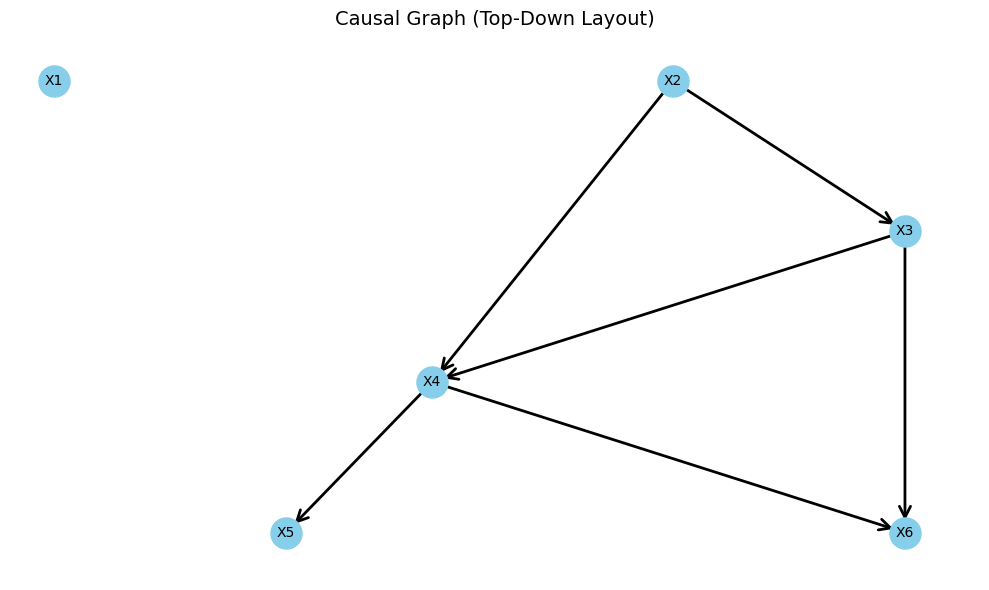

In [5]:
# 可视化因果图
import matplotlib.pyplot as plt


pos = nx.nx_pydot.pydot_layout(dag, prog='dot')      # 否则用 pydot

plt.figure(figsize=(10, 6))

# 画节点
nx.draw_networkx_nodes(dag, pos, node_size=500, node_color='skyblue')

# 画边（从上往下）
nx.draw_networkx_edges(
    dag, pos,
    arrows=True,
    arrowstyle='->',
    arrowsize=20,
    width=2
)

# 标签
nx.draw_networkx_labels(dag, pos, font_size=10)

plt.title("Causal Graph (Top-Down Layout)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.savefig('./results/causal_graph.png')
plt.show()


In [6]:
from dowhy import gcm
from dowhy.gcm.auto import AssignmentQuality


# 🟢 设置GCM模型的随机种子
np.random.seed(42)
random.seed(42)

scm = gcm.InvertibleStructuralCausalModel(dag)
summary = gcm.auto.assign_causal_mechanisms(
    scm, df, quality=AssignmentQuality.GOOD
)
gcm.fit(scm, df)

d:\ANACONDA\envs\dice_XAI\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Fitting causal mechanism of node X6: 100%|██████████| 6/6 [00:00<00:00, 99.08it/s]


In [7]:
gcm.counterfactual_samples(
    scm,
    {'X1': lambda x: 1},   # 保证 shape 相同
    observed_data=df[:1]
)[df_X.columns]

,X1,X2,X3,X4,X5,X6
0,1,-0.751156,2.649914,2.807496,3.078387,-2.933621


In [8]:
from tensorflow import keras
from tensorflow.keras.utils import to_categorical


def build_simple_dnn():
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(8, activation='relu', input_shape=(6,)))  # 输入31维特征
    model.add(keras.layers.Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

set_seed(1)

model = build_simple_dnn()

# 6️⃣ 训练模型
model.fit(X_train, to_categorical(y_train), epochs=10, batch_size=8, verbose=1)


Epoch 1/10
50/50 [==============================] - 1s 3ms/step - loss: 1.4117 - accuracy: 0.1950
Epoch 2/10
50/50 [==============================] - 0s 2ms/step - loss: 0.8894 - accuracy: 0.3575
Epoch 3/10
50/50 [==============================] - 0s 2ms/step - loss: 0.5921 - accuracy: 0.6400
Epoch 4/10
50/50 [==============================] - 0s 3ms/step - loss: 0.4247 - accuracy: 0.8400
Epoch 5/10
50/50 [==============================] - 0s 3ms/step - loss: 0.3333 - accuracy: 0.8825
Epoch 6/10
50/50 [==============================] - 0s 2ms/step - loss: 0.2847 - accuracy: 0.8925
Epoch 7/10
50/50 [==============================] - 0s 2ms/step - loss: 0.2550 - accuracy: 0.8975
Epoch 8/10
50/50 [==============================] - 0s 3ms/step - loss: 0.2367 - accuracy: 0.9025
Epoch 9/10
50/50 [==============================] - 0s 4ms/step - loss: 0.2234 - accuracy: 0.9100
Epoch 10/10
50/50 [==============================] - 0s 3ms/step - loss: 0.2132 - accuracy: 0.9125


In [9]:
import importlib
import dice_causal_random

importlib.reload(dice_causal_random)

from dice_causal_random import CausalRandom


# Using sklearn backend
m = dice_ml.Model(model=model, 
                  backend="TF2")


# 🟢 使用固定的随机种子创建CausalRandom实例
exp = CausalRandom(d, m, scm, random_seed=42)
# 快速测试
e1 = exp.generate_counterfactuals(
    X_test_df[:40],
    total_CFs=4,
    sample_size=500,
    random_seed=42  # 🟢 确保传入固定的随机种子
)

100%|██████████| 40/40 [36:49<00:00, 55.25s/it] 


In [10]:
e1.cf_examples_list[30].test_instance_df

,X1,X2,X3,X4,X5,X6,Y
0,-0.96867,-0.509821,0.943539,0.957314,0.087116,-1.260804,0


In [11]:
e1.cf_examples_list[30].final_cfs_df


,X1,X2,X3,X4,X5,X6,Y
0,1.526082,-0.509821,0.943539,0.957314,0.087116,-1.260804,1
1,-0.833710,-0.509821,-0.166433,-1.473523,-4.052720,-1.319865,1
2,1.317607,-0.509821,0.943539,0.957314,0.087116,-1.260804,1
3,-0.968670,-1.125397,1.288555,-0.623208,-2.551038,-2.994741,1


In [12]:
# 取出反事实样本（去掉 Y 列）
cf_samples = e1.cf_examples_list[30].final_cfs_df.drop(columns=['Y'])

# 转成 numpy array
cf_array = cf_samples.values

# 用模型预测
preds = model.predict(cf_array)


print(preds)

1/1 [==============================] - 0s 82ms/step
[[0.42516544 0.5748346 ]
 [0.11691798 0.88308203]
 [0.4368765  0.5631235 ]
 [0.28333458 0.7166654 ]]


In [13]:
print(e1.cf_examples_list[0].intervention_log)
node1_1 = e1.cf_examples_list[0].intervention_log[0, 0][0]


[[('X1', 1.50801828816) ('X5', 0.175849182)]
 [('X1', 1.61965024916) ('X4', 0.905316858)]
 [('X5', -2.608763865) ('X3', 1.320082045)]
 [('X1', -1.23264765121) ('X3', -0.152362612)]]


In [14]:
# 聚合所有反事实
all_cfs = pd.concat([cf.final_cfs_df for cf in e1.cf_examples_list],
                    ignore_index=True)

print(all_cfs.shape)
print(all_cfs.head())

(160, 7)
         X1        X2        X3        X4        X5        X6  Y
0  1.508018 -0.953438  1.609311  2.492076  0.175849 -1.917550  1
1  1.619650 -0.953438  1.609311  0.905317  0.315574 -3.101052  1
2  0.154981 -0.953438  1.609311  2.492076 -2.608764 -1.917550  1
3 -1.232648 -0.953438 -0.152363 -1.432318 -3.666541 -1.983874  1
4  0.992848 -1.468147  2.694949  1.306125 -0.540152 -2.667939  1


Test permutations of given graph: 100%|██████████| 50/50 [00:08<00:00,  6.03it/s]


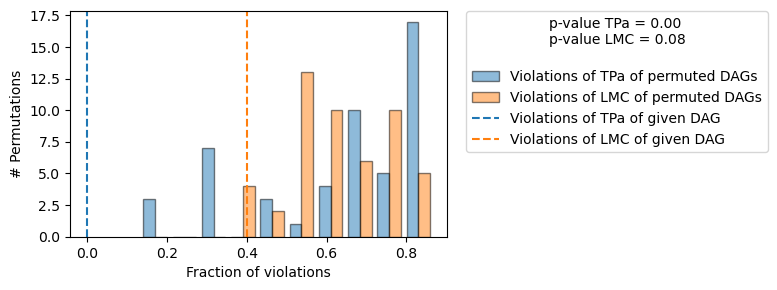

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [15]:
summary_evaluation = gcm.evaluate_causal_model(scm, all_cfs, compare_mechanism_baselines=True)
print(summary_evaluation)

In [16]:
# Using method=random for generating CFs
exp = dice_ml.Dice(d, m,
                   method="random")

e2 = exp.generate_counterfactuals(
    X_test_df[:40],
    total_CFs=4,
    desired_class="opposite",
    features_to_vary = 'all',
    sample_size=500
)

100%|██████████| 40/40 [02:37<00:00,  3.94s/it]


Test permutations of given graph: 100%|██████████| 50/50 [00:03<00:00, 16.16it/s]


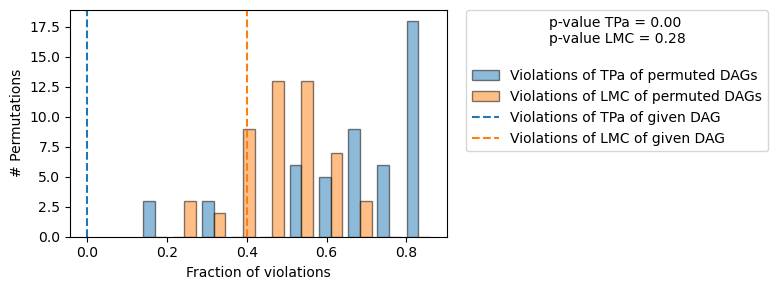

Evaluated the performance of the causal mechanisms and the invertibility assumption of the causal mechanisms and the overall average KL divergence between generated and observed distribution and the graph structure. The results are as follows:

==== Evaluation of Causal Mechanisms ====
The used evaluation metrics are:
- KL divergence (only for root-nodes): Evaluates the divergence between the generated and the observed distribution.
- Mean Squared Error (MSE): Evaluates the average squared differences between the observed values and the conditional expectation of the causal mechanisms.
- Normalized MSE (NMSE): The MSE normalized by the standard deviation for better comparison.
- R2 coefficient: Indicates how much variance is explained by the conditional expectations of the mechanisms. Note, however, that this can be misleading for nonlinear relationships.
- F1 score (only for categorical non-root nodes): The harmonic mean of the precision and recall indicating the goodness of the under

In [17]:
# 聚合所有反事实
all_cfs_random = pd.concat([cf.final_cfs_df for cf in e2.cf_examples_list],
                    ignore_index=True)
summary_evaluation = gcm.evaluate_causal_model(scm, all_cfs_random, compare_mechanism_baselines=True)
print(summary_evaluation)

In [20]:
df.to_csv('./results/df.csv', index=False)
all_cfs.to_csv('./results/all_cfs.csv', index=False)
all_cfs_random.to_csv('./results/all_cfs_random.csv', index=False)